In [1]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
data_dir = "stochastic_simulations/data/"

# Analyze trained

In [3]:
model_trained = tf.keras.models.load_model("trained/trained_final")

# Load lowest validation weights
model_trained.load_weights("trained/weights_lowest_val")

In [4]:
td = TrainingGaussData()
td.read_output_standardizations("cache")

## Integrate

In [46]:
params0_traj = Params0GaussTraj.fromFile("cache/cache_filtered.txt", nv=2)
tpt_start = 0
params0_start = params0_traj.params0_traj[tpt_start]

params0_traj_int = model_trained.integrate(
    params0_start=params0_start,
    tpt_start=tpt_start,
    no_steps=70,
    time_interval=0.1,
    output_mean=td.train_outputs_mean,
    output_std_dev=td.train_outputs_std_dev,
    non_zero_idx_pairs_vv=[(0,0),(1,0),(1,1)]
)

0 / 70 ...
7 / 70 ...
14 / 70 ...
21 / 70 ...
28 / 70 ...
35 / 70 ...
42 / 70 ...
49 / 70 ...


InvalidArgumentError: Input is not invertible. [Op:MatrixInverse]

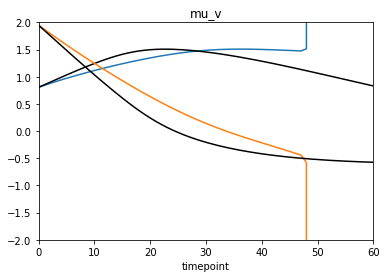

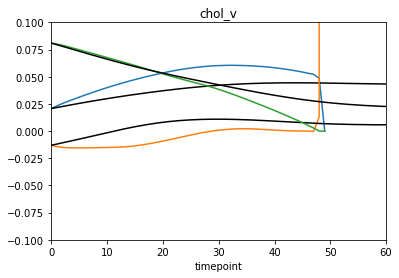

In [44]:
plt.figure()
plt.plot([x.mu_v[0] for x in params0_traj_int.params0_traj])
plt.plot([x.mu_v[0] for x in params0_traj.params0_traj],'k')
plt.plot([x.mu_v[1] for x in params0_traj_int.params0_traj])
plt.plot([x.mu_v[1] for x in params0_traj.params0_traj],'k')
plt.title("mu_v")
plt.xlabel("timepoint")
plt.xlim(0,60)
plt.ylim(-2,2)
plt.savefig("figures/integrated_mu_v.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params0_traj_int.params0_traj])
plt.plot([x.chol_v[0,0] for x in params0_traj.params0_traj],'k')
plt.plot([x.chol_v[1,0] for x in params0_traj_int.params0_traj])
plt.plot([x.chol_v[1,0] for x in params0_traj.params0_traj],'k')
plt.plot([x.chol_v[1,1] for x in params0_traj_int.params0_traj])
plt.plot([x.chol_v[1,1] for x in params0_traj.params0_traj],'k')
plt.title("chol_v")
plt.xlabel("timepoint")
plt.xlim(0,60)
plt.ylim(-0.1,0.1)
plt.savefig("figures/integrated_chol_v.png", dpi=200)

In [39]:
chol_v_0_0 = [x.chol_v[0,0] for x in params0_traj_int.params0_traj]
chol_v_1_0 = [x.chol_v[1,0] for x in params0_traj_int.params0_traj]
chol_v_1_1 = [x.chol_v[1,1] for x in params0_traj_int.params0_traj]

precs_int = []
covs_int = []
for i in range(0,len(chol_v_0_0)-1):
    chol = np.array([[chol_v_0_0[i],0.0],[chol_v_1_0[i],chol_v_1_1[i]]])
    prec = np.dot(chol,np.transpose(chol))
    precs_int.append(prec)
    cov = np.linalg.inv(prec)
    covs_int.append(cov)

chol_v_0_0 = [x.chol_v[0,0] for x in params0_traj.params0_traj]
chol_v_1_0 = [x.chol_v[1,0] for x in params0_traj.params0_traj]
chol_v_1_1 = [x.chol_v[1,1] for x in params0_traj.params0_traj]

precs = []
covs = []
for i in range(0,len(chol_v_0_0)-1):
    chol = np.array([[chol_v_0_0[i],0.0],[chol_v_1_0[i],chol_v_1_1[i]]])
    prec = np.dot(chol,np.transpose(chol))
    precs.append(prec)
    cov = np.linalg.inv(prec)
    covs.append(cov)

In [40]:
print([x[0,0] for x in covs][-9:])
print([x[1,0] for x in covs][-9:])
print([x[1,1] for x in covs][-9:])

[0.7130539673081964, 0.7187379693264365, 0.7250570843335314, 0.7321121160221801, 0.7400170876037822, 0.7489013075449178, 0.7589114468450915, 0.7702146562892543, 0.7830022728317245]
[-0.30382232650964863, -0.3244695099920439, -0.34694499494656184, -0.37145397962234405, -0.39823316545366205, -0.4275558551980098, -0.45973714840699753, -0.4951419809323128, -0.5341956873175202]
[1.040518000275091, 1.09280372275003, 1.1500710212289498, 1.2127685598644156, 1.28141049104844, 1.356588600438515, 1.4389851468787616, 1.5293945562866809, 1.6287542344528383]


(-1000.0, 20000.0)

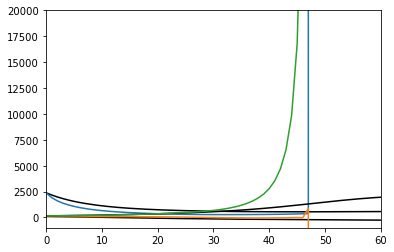

In [47]:
plt.figure()
plt.plot([x[0,0] for x in covs],'k')
plt.plot([x[0,0] for x in covs_int])
plt.plot([x[1,0] for x in covs],'k')
plt.plot([x[1,0] for x in covs_int])
plt.plot([x[1,1] for x in covs],'k')
plt.plot([x[1,1] for x in covs_int])
plt.xlim(0,60)
plt.ylim(-1000,20000)

(-1000.0, 5000.0)

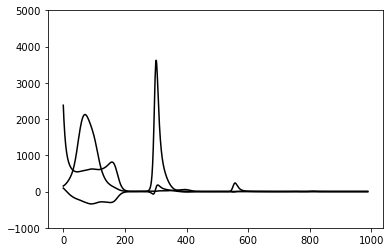

In [52]:
plt.figure()
plt.plot([x[0,0] for x in covs],'k')
plt.plot([x[1,0] for x in covs],'k')
plt.plot([x[1,1] for x in covs],'k')
plt.ylim(-1000,5000)

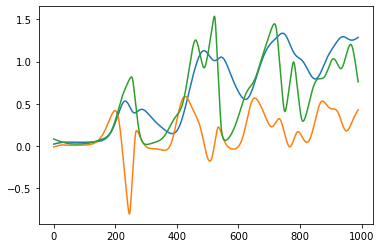

In [48]:
chol_v_0_0 = [x.chol_v[0,0] for x in params0_traj.params0_traj]
chol_v_1_0 = [x.chol_v[1,0] for x in params0_traj.params0_traj]
chol_v_1_1 = [x.chol_v[1,1] for x in params0_traj.params0_traj]
plt.figure()
plt.plot(chol_v_0_0)
plt.plot(chol_v_1_0)
plt.plot(chol_v_1_1)

# Train comparison model

In [62]:
compare_lyr = ComparisonInputsLayer.construct_zero_init(
    nv=2,
    nh=1,
    freqs=freqs
    )

In [63]:
model = ComparisonModel.construct(
    nv=2,
    nh=1,
    compare_lyr=compare_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

In [64]:
# Reaction layer to use for the normalization
compare_lyr_norm = ComparisonInputsLayer.construct_one_init(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]])
    )

# Normalize inputs
model.calculate_param_normalization(
    compare_lyr=compare_lyr_norm,
    inputs=td.train_inputs, 
    percent=0.2
    )

Calculating input normalization from: 558 samples


In [65]:
print("Param normalization: Mean: ", model.param_mean)
print("Param normalization: Std dev: ", model.param_std_dev)

Param normalization: Mean:  [-7.0482546e-01  5.5520162e-05 -9.6994251e-02 -3.6622068e-01
  0.0000000e+00  2.2564167e-02  1.0325634e+00]
Param normalization: Std dev:  [2.5104061e-01 1.7341879e-05 4.4773069e-01 2.0861846e-01 1.0000000e+00
 5.0192004e-01 5.0191993e-01]


## Train

In [66]:
# Build model by running it once
input0 = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=0)
output0 = model(input0)

In [67]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

logdir = os.path.join("logs_compare", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained_compare/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

model.fit(
    td.train_inputs, 
    td.train_outputs_stdrd, 
    epochs=25, 
    validation_data=(td.valid_inputs,td.valid_outputs_stdrd),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

# Save
model.save("trained_compare/trained_final", save_traces=False)

Epoch 1/25
44/44 [==============================] - 4s 49ms/step - loss: 2.1117 - b0_TE_loss: 1.0736 - wt00_TE_loss: 1.0381 - val_loss: 0.7408 - val_b0_TE_loss: 0.4621 - val_wt00_TE_loss: 0.2787

Epoch 00001: val_loss improved from inf to 0.74081, saving model to trained_compare/weights_lowest_val
Epoch 2/25
44/44 [==============================] - 1s 25ms/step - loss: 1.7611 - b0_TE_loss: 0.8624 - wt00_TE_loss: 0.8987 - val_loss: 0.6291 - val_b0_TE_loss: 0.3712 - val_wt00_TE_loss: 0.2579

Epoch 00002: val_loss improved from 0.74081 to 0.62911, saving model to trained_compare/weights_lowest_val
Epoch 3/25
44/44 [==============================] - 1s 24ms/step - loss: 1.4226 - b0_TE_loss: 0.6712 - wt00_TE_loss: 0.7514 - val_loss: 0.6471 - val_b0_TE_loss: 0.3430 - val_wt00_TE_loss: 0.3041

Epoch 00003: val_loss did not improve from 0.62911
Epoch 4/25
44/44 [==============================] - 1s 26ms/step - loss: 1.1101 - b0_TE_loss: 0.5208 - wt00_TE_loss: 0.5893 - val_loss: 0.7577 - val_b0

# Analyze trained

In [68]:
model_trained = tf.keras.models.load_model("trained_compare/trained_final")

# Load lowest validation weights
model_trained.load_weights("trained_compare/weights_lowest_val")

In [69]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p600", nv=2, nh=1)

tpt_start = 0
params_start = params_traj.params_traj[tpt_start]

params_traj_int = model.integrate(
    params_start=params_start,
    tpt_start=tpt_start,
    no_steps=400,
    time_interval=0.1,
    output_mean=td.train_outputs_mean,
    output_std_dev=td.train_outputs_std_dev
)

0 / 400 ...
40 / 400 ...
80 / 400 ...
120 / 400 ...
160 / 400 ...
200 / 400 ...
240 / 400 ...
280 / 400 ...
320 / 400 ...
360 / 400 ...


Text(0.5, 1.0, 'sig2')

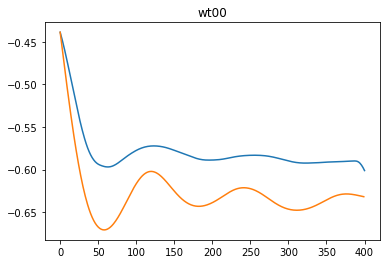

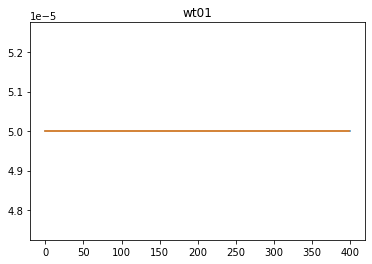

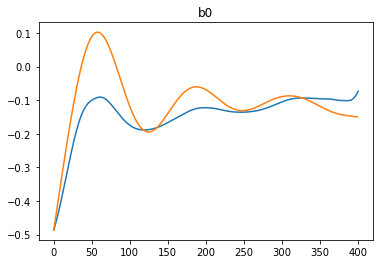

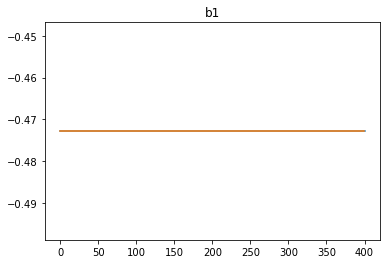

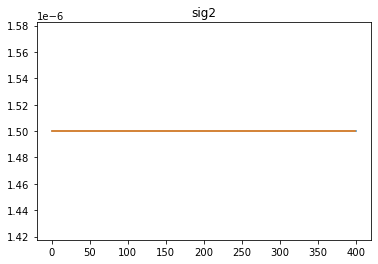

In [70]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
wt01 = [x.wt[0,1] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]
b1 = [x.b[1] for x in params_traj_int.params_traj]
sig2 = [x.sig2 for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
wt01_true = [x.wt[0,1] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]
b1_true = [x.b[1] for x in params_traj.params_traj]
sig2_true = [x.sig2 for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)
plt.title("wt00")

plt.figure()
plt.plot(wt01)
plt.plot(wt01_true)
plt.title("wt01")

plt.figure()
plt.plot(b0)
plt.plot(b0_true)
plt.title("b0")

plt.figure()
plt.plot(b1)
plt.plot(b1_true)
plt.title("b1")

plt.figure()
plt.plot(sig2)
plt.plot(sig2_true)
plt.title("sig2")

## Accuracy

In [20]:
def make_input_single(idx, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array([val[idx]])
    return in0

def make_output_single(idx, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array([val[idx]])
    return out0_norm_true

def make_input_multiple(idxs, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array(val[idxs])
    return in0

def make_output_multiple(idxs, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array(val[idxs])
    return out0_norm_true

def test_output_np(in0):
    out0_norm = model(in0)
    for key,val in out0_norm.items():
        out0_norm[key] = val.numpy()
    return out0_norm

In [21]:
idx = 15
in0 = make_input_single(idx, train_inputs)
out0_norm_true = make_output_single(idx, train_outputs_norm)

print("Input:",in0)
print("Output normalized true:",out0_norm_true)
out0_norm = test_output_np(in0)
print("Output true:", out0_norm)

Input: {'tpt': array([15.]), 'wt': array([[[-3.24692148e-01,  5.00000000e-05]]]), 'b': array([[-0.59687188, -0.68348013]]), 'sig2': array([1.5e-06])}
Output normalized true: {'wt00_TE': array([-3.37807944]), 'b0_TE': array([1.28487952])}
Output true: {'wt00_TE': array([[-3.3489437]], dtype=float32), 'b0_TE': array([[1.4640167]], dtype=float32)}


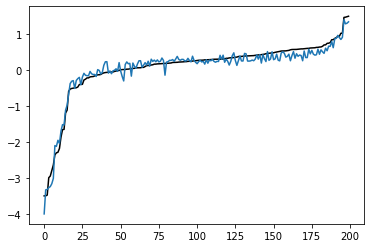

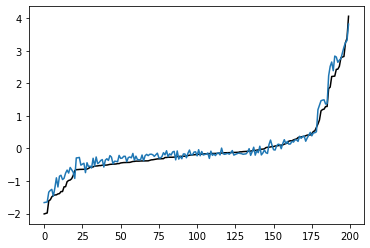

In [22]:
no_inputs = len(train_inputs["wt"])
idxs = np.arange(0,no_inputs)
np.random.shuffle(idxs)
idxs = idxs[:200]

in0 = make_input_multiple(idxs, train_inputs)
out0_norm_true = make_output_multiple(idxs, train_outputs_norm)
out0_norm = test_output_np(in0)

idxs_sort = out0_norm_true["wt00_TE"].argsort()
x_true = out0_norm_true["wt00_TE"][idxs_sort]
x = out0_norm["wt00_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

idxs_sort = out0_norm_true["b0_TE"].argsort()
x_true = out0_norm_true["b0_TE"][idxs_sort]
x = out0_norm["b0_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

## Latent representation learned

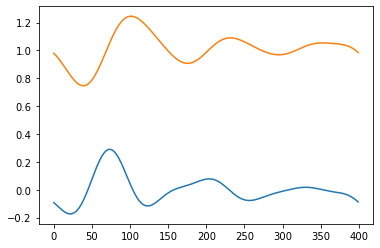

In [57]:
input0 = {
    "tpt": np.reshape(np.arange(0,400).astype('float32'),newshape=(400,1))
    }
muh_lyr = model_trained.compare_lyr.params0toParams.layer_muh["0"]
muh_output0 = muh_lyr(input0).numpy()
varh_diag_lyr = model_trained.compare_lyr.params0toParams.layer_varh_diag["0"]
varh_diag_output0 = varh_diag_lyr(input0).numpy()

plt.figure()
plt.plot(muh_output0)
plt.plot(varh_diag_output0)